In [4]:
import nltk
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

# word to vec
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim import models

import numpy as np
from math import exp
from numpy import sign
from ast import literal_eval
import json

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# Importing preprocessed file from week 1
df = pd.read_csv('/content/gdrive/MyDrive/week1_processed.csv',error_bad_lines=False, index_col = False)
df.drop('Unnamed: 0', inplace=True, axis=1)
df.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,Sentiment,SentimentText
0,0,sad apl friend
1,0,missed new moon trailer
2,1,omg already 730
3,0,omgaga im sooo im gunna cry ive dentist since ...
4,0,think mi bf cheating tt


In [8]:
#splitting tweet strings
df = df[df['SentimentText'].notnull()]
documents = [_text.split() for _text in df['SentimentText']]

In [6]:
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)


w2v_model.build_vocab(documents)

In [7]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(332389875, 396565856)

In [8]:
w2v_model.wv.save_word2vec_format('/content/gdrive/MyDrive/model.bin', binary=True)

In [5]:
w2v_model = models.KeyedVectors.load_word2vec_format('/content/gdrive/MyDrive/model.bin', binary=True)

In [9]:
df['SentimentText'] = df['SentimentText'].apply(str)
tokenizer = Tokenizer(num_words= 400, split=' ')
tokenizer.fit_on_texts(df['SentimentText'].values)
X = tokenizer.texts_to_sequences(df['SentimentText'].values)
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 32
X = pad_sequences(X , maxlen = SEQUENCE_LENGTH)
vocab_size = len(tokenizer.word_index)+1

In [11]:
embedding_matrix = np.zeros((vocab_size , 300))
for word , i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

<ipython-input-11-487e8443de07>:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in w2v_model.wv:
<ipython-input-11-487e8443de07>:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  embedding_matrix[i] = w2v_model.wv[word]


(768648, 300)


In [13]:
embedding_layer = Embedding( vocab_size , 300 , weights = [embedding_matrix] , input_length = SEQUENCE_LENGTH, trainable = False)
model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          230594400 
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 300)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               335808    
                                                                 
 dense (Dense)               (None, 2)                 354       
                                                                 
Total params: 230,930,562
Trainable params: 336,162
Non-trainable params: 230,594,400
_________________________________________________________________
None


In [16]:
Y =pd.get_dummies(df['Sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 42, test_size = 0.2,train_size = 0.02)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42,train_size = 0.02)

In [17]:
batch_size=32
hist = model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, validation_data=(X_val, Y_val), verbose = 'auto')

Epoch 1/10
20/20 [==============================] - 107s 6s/step - loss: 0.5514 - accuracy: 0.7290 - val_loss: 0.5607 - val_accuracy: 0.7128
Epoch 2/10
20/20 [==============================] - 105s 5s/step - loss: 0.5440 - accuracy: 0.7369 - val_loss: 0.5647 - val_accuracy: 0.7109
Epoch 3/10
20/20 [==============================] - 104s 5s/step - loss: 0.5042 - accuracy: 0.7353 - val_loss: 0.5675 - val_accuracy: 0.7082
Epoch 4/10
20/20 [==============================] - 107s 6s/step - loss: 0.5004 - accuracy: 0.7528 - val_loss: 0.5736 - val_accuracy: 0.7057
Epoch 5/10
20/20 [==============================] - 106s 5s/step - loss: 0.4690 - accuracy: 0.7845 - val_loss: 0.5873 - val_accuracy: 0.7008
Epoch 6/10
20/20 [==============================] - 112s 6s/step - loss: 0.4253 - accuracy: 0.7956 - val_loss: 0.5998 - val_accuracy: 0.6989
Epoch 7/10
20/20 [==============================] - 113s 6s/step - loss: 0.3982 - accuracy: 0.8288 - val_loss: 0.6292 - val_accuracy: 0.6911
Epoch 8/10
20

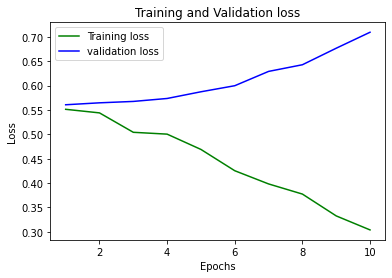

In [18]:
loss_train = hist.history['loss']
loss_val = hist.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

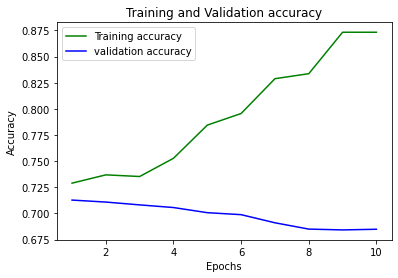

In [19]:
acc_train = hist.history['accuracy']
acc_val = hist.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
sco , accu = model.evaluate(X_test,Y_test)
print("accuracy of LSTM model: %.2f" % (accu*100),"%")

9865/9865 [==============================] - 4251s 431ms/step - loss: 0.6942 - accuracy: 0.6892
accuracy of LSTM model: 68.92 %


In [21]:

model.save_weights('/content/gdrive/MyDrive/model_weights.h5')
with open('/content/gdrive/MyDrive/model_architecture.json', 'w') as f:
    f.write(model.to_json())
    
model.save('/content/gdrive/MyDrive/entire_model.h5')
tokenizer_json = tokenizer.to_json()
with open('/content/gdrive/MyDrive/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [22]:

class LogReg:
    """
    Class to represent a logistic regression model.
    """

    def __init__(self, l_rate, epochs, n_features):
        """
        Create a new model with certain parameters.

        :param l_rate: Initial learning rate for model.
        :param epoch: Number of epochs to train for.
        :param n_features: Number of features.
        """
        self.l_rate = l_rate
        self.epochs = epochs
        self.coef = [0.0] * n_features
        self.bias = 0.0

    def sigmoid(self, score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.

        :param score: A real valued number to convert into a number between 0 and 1
        """
        if abs(score) > threshold:
            score = threshold * sign(score)
        activation = exp(score)
        return activation / (1.0 + activation)

    def predict(self, features):
        """
        Given an example's features and the coefficients, predicts the class.

        :param features: List of real valued features for a single training example.

        :return: Returns the predicted class (either 0 or 1).
        """
        value = sum([features[i]*self.coef[i] for i in range(len(features))]) + self.bias
        return self.sigmoid(value)

    def sg_update(self, features, label):
        """
        Computes the update to the weights based on a predicted example.

        :param features: Features to train on.
        :param label: Corresponding label for features.
        """
        yhat = self.predict(features)
        e = label - yhat
        self.bias = self.bias + self.l_rate * e * yhat * (1-yhat)
        for i in range(len(features)):
            self.coef[i] = self.coef[i] + self.l_rate * e * yhat * (1-yhat) * features[i]
        return

    def train(self, X, y):
        """
        Computes logistic regression coefficients using stochastic gradient descent.

        :param X: Features to train on.
        :param y: Corresponding label for each set of features.

        :return: Returns a list of model weight coefficients where coef[0] is the bias.
        """
        for epoch in range(self.epochs):
            for features, label in zip(X, y):
                self.sg_update(features, label)
        return self.bias, self.coef

def get_accuracy(y_bar, y_pred):
    """
    Computes what percent of the total testing data the model classified correctly.

    :param y_bar: List of ground truth classes for each example.
    :param y_pred: List of model predicted class for each example.

    :return: Returns a real number between 0 and 1 for the model accuracy.
    """
    correct = 0
    for i in range(len(y_bar)):
        if y_bar[i] == y_pred[i]:
            correct += 1
    accuracy = (correct / len(y_bar)) * 100.0
    return accuracy        

In [23]:
logreg = LogReg(0.1, 5, len(X_train[0]))
bias_logreg, weights_logreg = logreg.train(X_train, Y_train[:,0])
y_logistic = [round(logreg.predict(example)) for example in X_test]

In [24]:
accuracy_logistic = get_accuracy(y_logistic, Y_test[:,0])
print('Logistic Regression Accuracy: {:0.2f}'.format(accuracy_logistic))

Logistic Regression Accuracy: 50.48
